# IA para espacialização dos dados

In [1]:
import os
import rasterio
import numpy as np
import pandas as pd
import asciichartpy
import seaborn as sns
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

from tqdm import tqdm, trange
from pyproj import Transformer
from utils.consts import SOIL_TYPES, USO_SOLO_CLASS
from rasterio.transform import rowcol
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split

### Device disponível para treinar o modelo MLP

In [2]:
# 1) Dispositivo (GPU se disponível)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


### Dataset com os dados para convolução
---
- O Dataset nesta aplicação é extremamente importante pois irá englobar todas as informações necessárias para espacializar os dado de infiltração

Lendo Tabelas
Lendo Rasteres
Correlações:


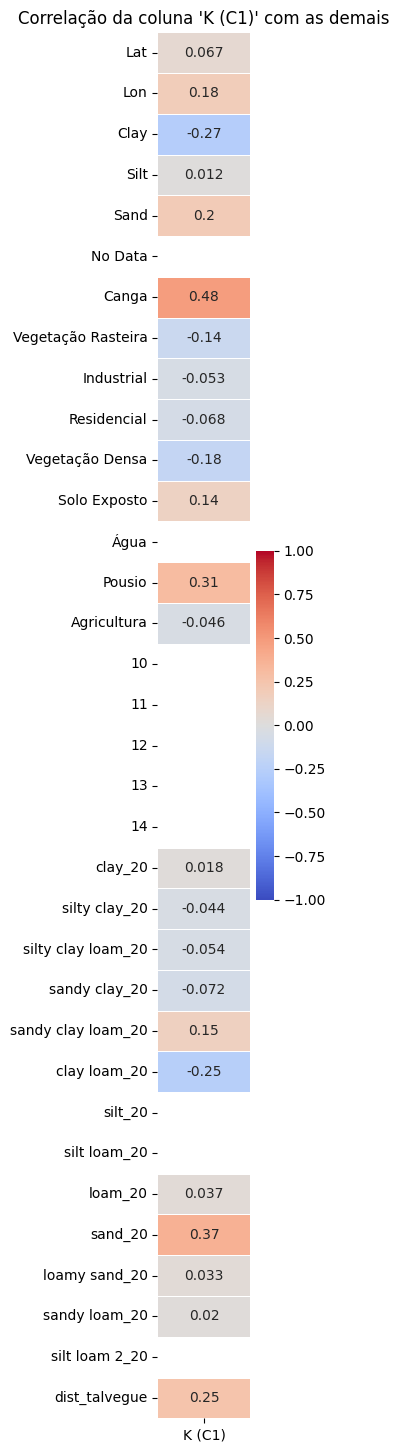

Len: 83


(torch.Size([20]), torch.Size([10, 20]))

In [3]:
# 2) Dataset
class MeuDataset(Dataset):
    nix_bands = [
        "R400 nm", "R410 nm", "R420 nm", "R430 nm",
        "R440 nm", "R450 nm", "R460 nm", "R470 nm",
        "R480 nm", "R490 nm", "R500 nm", "R510 nm",
        "R520 nm", "R530 nm", "R540 nm", "R550 nm",
        "R560 nm", "R570 nm", "R580 nm", "R590 nm",
        "R600 nm", "R610 nm", "R620 nm", "R630 nm",
        "R640 nm", "R650 nm", "R660 nm", "R670 nm",
        "R680 nm", "R690 nm", "R700 nm",
    ]

    columns_dados = ["Ponto", "Lat", "Lon", "soils_type", "Clay", "Silt", "Sand", "K (C1)"]

    def __init__(self, device:torch.device|None=None):
        """
        O dataset tem o formato de uma tupla com os valores em X e em Y:
        - (X, Y)
        - Onde:
        - X: (rasters_vals, [Dist. Talvegue, Tipo do Solo, na ordem de soil_types])
        - Y: K (cm/s)
        """
        self.device = device

        # Lendo Tabelas
        print("Lendo Tabelas")
        self.dados = pd.read_excel(r"D:\Mestrado\Trabalho Final\Dados\Levantamento em Campo\Compiled.xlsx", sheet_name="Infiltracao")
        self.dados = self.dados[self.columns_dados].dropna().reset_index(drop=True)
        gdf = gpd.GeoDataFrame(self.dados, geometry=gpd.points_from_xy(self.dados["Lat"], self.dados["Lon"]), crs="EPSG:4326")
        gdf.to_crs("EPSG:31983", inplace=True)
        self.dados['Lat'] = gdf.geometry.y
        self.dados['Lon'] = gdf.geometry.x

        self.nix = pd.read_excel(r"D:\Mestrado\Trabalho Final\Dados\Levantamento em Campo\Compiled.xlsx", sheet_name="Nix")
        self.pXRF = pd.read_excel(r"D:\Mestrado\Trabalho Final\Dados\Levantamento em Campo\Compiled.xlsx", sheet_name="pXRF")

        # Lendo Rasteres importantes
        self.talvegues = gpd.read_file(r"D:/Mestrado/Trabalho Final/SIG/HidrografiaArea.zip")

        # Lendo Rasteres
        print("Lendo Rasteres")
        self.uso_solo        = rxr.open_rasterio(r"D:/Mestrado/Trabalho Final/SIG/USOSOLO.tif")                 # Tipos de uso do solo
        self.elevation       = rxr.open_rasterio(r"D:/Mestrado/Trabalho Final/SIG/Elevation.tif")               # Elevação
        self.terrain_rug_idx = rxr.open_rasterio(r"D:/Mestrado/Trabalho Final/SIG/TerrainRuggednessIndex.tif")  # Variação de elevação entre um pixel e seus vizinhos imediatos
        self.topo_pos_idx    = rxr.open_rasterio(r"D:/Mestrado/Trabalho Final/SIG/TopograficPositionIndex.tif") # Elevação de um ponto com a média da elevação ao redor, topo, vale ou plano
        self.roughness       = rxr.open_rasterio(r"D:/Mestrado/Trabalho Final/SIG/Roughness.tif")               # A diferença entre a elevação máxima e mínima dentro de uma vizinhança
        self.slope           = rxr.open_rasterio(r"D:/Mestrado/Trabalho Final/SIG/Slope.tif")                   # Declividade
        self.aspect          = rxr.open_rasterio(r"D:/Mestrado/Trabalho Final/SIG/Aspect.tif")                  # Para onde "aponta" a face do terreno
        self.texture_02      = rxr.open_rasterio(r"D:\Mestrado\Trabalho Final\SIG\textura_2.tif")               # Textura a 2 cm
        self.texture_20      = rxr.open_rasterio(r"D:\Mestrado\Trabalho Final\SIG\textura_20.tif")              # Textura a 20 cm

        self.transformer = Transformer.from_crs("EPSG:31983", self.uso_solo.rio.crs, always_xy=True) # type: ignore
        self.transform = self.uso_solo.rio.transform() # type: ignore

        self._process_dados()

    def _process_dados(self):
        self.columns = ["dist_talvegue", 'Canga', 'Vegetação Rasteira', 'Vegetação Densa', 'Solo Exposto', 'Pousio', 'Agricultura']
        # self.columns += [i+"_02" for i in SOIL_TYPES if i is not None]
        self.columns += [i+"_20" for i in SOIL_TYPES if i is not None]

        # Dados para convolução
        x, y = self.transformer.transform(self.dados["Lon"], self.dados["Lat"])
        row, col = rowcol(self.transform, x, y)

        # Uso do solo
        usos = self.uso_solo.values[0][row, col] # type: ignore
        for tipo_uso, dados in USO_SOLO_CLASS.items():
            self.dados[dados["name"]] = np.where(usos==tipo_uso, 1, 0)
        
        # Tipo do solo a 02cm
        # tipos_02 = self.texture_02.values[0][row, col] # type: ignore
        # for idx, soil_type in enumerate(SOIL_TYPES):
        #     if soil_type is None:
        #        continue
        #     self.dados[soil_type+"_02"] = np.where(tipos_02==idx, 1, 0)

        # Tipo do solo a 20cm
        tipos_20 = self.texture_02.values[0][row, col] # type: ignore
        for idx, soil_type in enumerate(SOIL_TYPES):
            if soil_type is None:
               continue
            self.dados[soil_type+"_20"] = np.where(tipos_20==idx, 1, 0)

        # Distância até o talvegue principal
        linhas_unidas = self.talvegues.union_all()
        pontos = gpd.GeoSeries(gpd.points_from_xy(self.dados["Lon"], self.dados["Lat"]), crs="EPSG:31983")
        dists = pontos.apply(lambda p: p.distance(linhas_unidas))
        self.dados["dist_talvegue"] = dists

        print("Correlações:")
        correlacoes = self.dados.corr(numeric_only=True)["K (C1)"].drop("K (C1)")

        plt.figure(figsize=(1.5, len(correlacoes) * 0.5 + 1))
        sns.heatmap(
            correlacoes.to_frame(),     # transforma em DataFrame para usar como matriz
            cmap='coolwarm',
            annot=True,
            vmin=-1, vmax=1,
            cbar=True,
            linewidths=0.5
        )

        plt.title("Correlação da coluna 'K (C1)' com as demais")
        plt.show()


    def __len__(self):
        return len(self.dados)

    def __getitem__(self, i):
        idx = i
        if isinstance(i, (int, float)):
            idx = [i]

        # Pontos
        pontos = self.dados.loc[idx]

        # Demais dados
        K = torch.tensor(pontos["K (C1)"].values, device=self.device) * 1000 # K*1000 pois os valores estão baixos de mais

        values = torch.tensor(pontos[self.columns].values, device=self.device, dtype=torch.float64)

        if isinstance(i, (int, float)):
            values = values[0]
            K = K[0]


        return (values,), K
    
dataset = MeuDataset(device=device)

print("Len:", len(dataset))
dataset[15][0][0].shape, dataset[1:10][0][0].shape

### Configurações do treino
---

- Seed para números aleatórios
- % de treino e teste
- Métricas
- Epochs
- Batch Size

In [4]:
# Seed para permitir reprodutibilidade dos valores pseudo-aleatórios
seed = 42

# Porcentagens de Treino e Teste
train_percent = 85
test_percent  = 15

In [5]:
n = len(dataset)
n_train = int(train_percent*n/100)
n_test = n - n_train
g = torch.Generator().manual_seed(seed)

train_ds, test_ds = random_split(dataset, [n_train, n_test], generator=g)

print("N Total:", n, "N Train:", n_train, "N Teste:", n_test)

train_ds[1:5][0][0].shape, test_ds[1:5][0][0].shape # type: ignore

N Total: 83 N Train: 70 N Teste: 13


(torch.Size([4, 20]), torch.Size([4, 20]))

### Dados

In [6]:
X = dataset[:][0][0].cpu().numpy()
y = dataset[:][1].cpu().numpy()

In [7]:
X_train = train_ds[:][0][0].cpu().numpy() # type: ignore
y_train = train_ds[:][1].cpu().numpy() # type: ignore

In [8]:
X_test = test_ds[:][0][0].cpu().numpy() # type: ignore
y_test = test_ds[:][1].cpu().numpy() # type: ignore

### Random Forest
---

In [9]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
train_rf = rf.predict(X_train)
pred_rf = rf.predict(X_test)
serie_rf = rf.predict(X)
pred_rf

array([ 8.28015655,  1.76583409,  3.27231761,  1.68981607,  3.96563617,
       40.60657239, 18.41980226,  6.50994732,  2.59631691,  1.88057328,
        6.98053643,  3.76877432,  1.52281284])

### XGBoost
---

In [10]:
# XGBoost
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
train_xgb = xgb.predict(X_train)
pred_xgb = xgb.predict(X_test)
serie_xgb = xgb.predict(X)
pred_xgb

array([ 6.6891527,  1.2410587,  1.467147 ,  1.2975289,  3.0794365,
       63.80645  , 14.936298 ,  1.3253212,  1.4186361,  1.653279 ,
        8.557629 ,  3.6256049,  1.4255667], dtype=float32)

### Regressão Linear
---

In [11]:
# Linear
lin = LinearRegression()
lin.fit(X_train, y_train)
train_lin = lin.predict(X_train)
pred_lin = lin.predict(X_test)
serie_lin = lin.predict(X)
pred_lin

array([ 3.26694012,  3.21269347, -0.98354299,  1.1450875 ,  8.6328671 ,
       37.56975366, 24.7785401 , -0.14062855,  3.72047978,  1.48663404,
       -0.17693637,  1.14149417,  7.04090032])

### Métricas

In [12]:
def nse(y_pred, y_true, mean=None):
    if mean is not None:
        y_true_mean = mean
    else:
        y_true_mean = np.mean(y_true)
        
    numerator = np.sum((y_pred - y_true) ** 2)
    denominator = np.sum((y_true - y_true_mean) ** 2)
    return 1 - (numerator / denominator)

In [13]:
# Avaliação
print("Nos valores de validação")
print("RMSE - Random Forest:", root_mean_squared_error(y_test, pred_rf))
print("RMSE - XGBoost:", root_mean_squared_error(y_test, pred_xgb))
print("RMSE - Reg. Linear:", root_mean_squared_error(y_test, pred_lin))
print()
print("NSE - Random Forest:", nse(pred_rf, y_test, y.mean()))
print("NSE - XGBoost:", nse(pred_xgb, y_test, y.mean()))
print("NSE - Reg. Linear:", nse(pred_lin, y_test, y.mean()))
print("----------------------------------------------------")
print("Nos valores de treino")
print("RMSE - Random Forest:", root_mean_squared_error(y_train, train_rf))
print("RMSE - XGBoost:", root_mean_squared_error(y_train, train_xgb))
print("RMSE - Reg. Linear:", root_mean_squared_error(y_train, train_lin))
print()
print("NSE - Random Forest:", nse(train_rf, y_train, y.mean()))
print("NSE - XGBoost:", nse(train_xgb, y_train, y.mean()))
print("NSE - Reg. Linear:", nse(train_lin, y_train, y.mean()))
print("----------------------------------------------------")
print("Na série Toda:")
print("RMSE - Random Forest:", root_mean_squared_error(y, serie_rf))
print("RMSE - XGBoost:", root_mean_squared_error(y, serie_xgb))
print("RMSE - Reg. Linear:", root_mean_squared_error(y, serie_lin))
print()
print("NSE - Random Forest:", nse(serie_rf, y, y.mean()))
print("NSE - XGBoost:", nse(serie_xgb, y, y.mean()))
print("NSE - Reg. Linear:", nse(serie_lin, y, y.mean()))



Nos valores de validação
RMSE - Random Forest: 14.483355696944958
RMSE - XGBoost: 20.598022968249015
RMSE - Reg. Linear: 13.56843249852177

NSE - Random Forest: -0.4000817798982006
NSE - XGBoost: -1.831822882563067
NSE - Reg. Linear: -0.2287806603887279
----------------------------------------------------
Nos valores de treino
RMSE - Random Forest: 3.821575586567836
RMSE - XGBoost: 0.008526244174446551
RMSE - Reg. Linear: 5.840442590971355

NSE - Random Forest: 0.846763578950062
NSE - XGBoost: 0.9999992372317208
NSE - Reg. Linear: 0.6420943031944537
----------------------------------------------------
Na série Toda:
RMSE - Random Forest: 6.7210239257255555
RMSE - XGBoost: 8.151891081795894
RMSE - Reg. Linear: 7.5896922506624085

NSE - Random Forest: 0.5650067011376347
NSE - XGBoost: 0.36007596741214
NSE - Reg. Linear: 0.44529763634006003


### Plot das Previsões

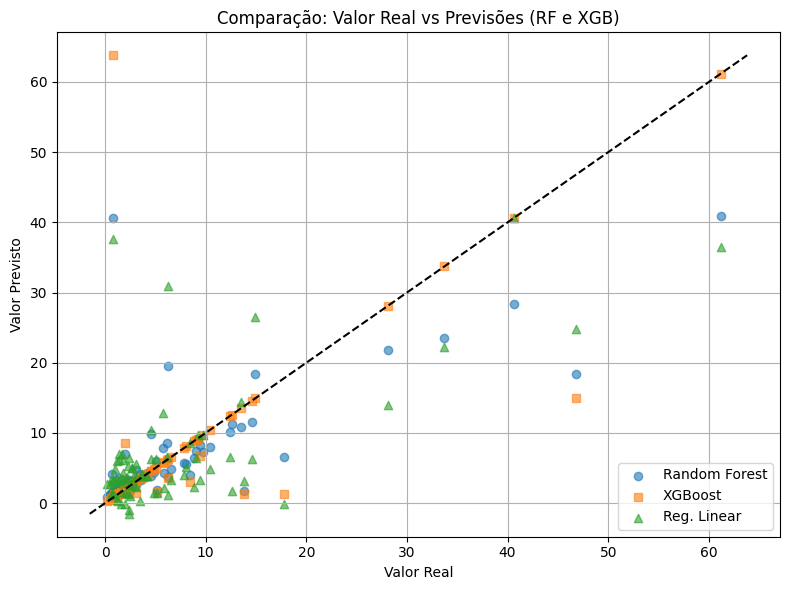

In [14]:
plt.figure(figsize=(8, 6))

# Real vs Random Forest
plt.scatter(y, serie_rf, alpha=0.6, label="Random Forest", marker='o')

# Real vs XGBoost
plt.scatter(y, serie_xgb, alpha=0.6, label="XGBoost", marker='s')

# Real vs Linear
plt.scatter(y, serie_lin, alpha=0.6, label="Reg. Linear", marker='^')

min_val = min(y.min(), serie_rf.min(), serie_xgb.min(), serie_lin.min())
max_val = max(y.max(), serie_rf.max(), serie_xgb.max(), serie_lin.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--')

# Estética
plt.xlabel("Valor Real")
plt.ylabel("Valor Previsto")
plt.title("Comparação: Valor Real vs Previsões (RF e XGB)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()